## Introduction
__Montpellier_Network__ is a python package designed to create a video and a widget showing a car, a pedestrian and a bicycle going from "La Maison du Lez" to "Place Eugène Bataillon" in Montpellier with the shortest path possible.This notebook has for goal to describe, step by step, how this work was done.

The animation will be created by creating a saquence of images, and then displaying them repeatedly one by one.

## Note :
In this report, we will work on the pedestrian case, the other cases are completely siimilar.

In [1]:
## importing all necessary packages
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
from matplotlib import animation
from PIL import Image, ImageOps
from math import radians, degrees, cos, sin, sqrt, atan2, asin, pi
import os
from copy import copy
from PIL import Image, ImageOps
import imageio
plt.ioff()
%matplotlib notebook

In order to avoid working with latitude and logitude, which is confusing, we decide to code a class, a point on earth's surface defined by its latitude and longuitude. This will help us to avoid confusing latitude and longuitude, and will also make our code more readable, and shorter.

In [3]:
## we will define a class 

class Point(object):
    """a point on earth's surface defined by its latitude and longuitude"""
    def __init__(self,lat,lon):
        self.lat = lat
        self.lon = lon

Now, the first thing to do is to plot the graph. We want the path between the origin point, and the destination point to be in the center of the graph, so we decide to create the `osmnx` graph from the midpoint between our origin and destiantion points. Unfortunetly, `osmnx` package doesn't offer any function to calculate the midpoint coordinates, so we will have to do it ourselves, the next function returns the midpoint of two points :

### Note :
The output of this function is a Point object, of the class we defined earlier.

In [4]:
def midpoint(A,B): 
    """return the midpoint (a Point object) of two points (Point objects)"""
    ## convert degrees to radians
    lat1, lon1 = radians(A.lat), radians(A.lon)
    lat2, lon2 = radians(B.lat), radians(B.lon)
    
    dLon = lon2-lon1

    Bx = cos(lat2) * cos(dLon)
    By = cos(lat2) * sin(dLon)
    
    ## applying the midpoint formula
    lat3 = atan2(sin(lat1)+sin(lat2), sqrt((cos(lat1)+Bx)*(cos(lat1)+Bx) + By*By))
    lon3 = lon1 + atan2(By, cos(lat1) + Bx)
    return Point(degrees(lat3),degrees(lon3))


Now let's plot the graphe from the the midpoint :

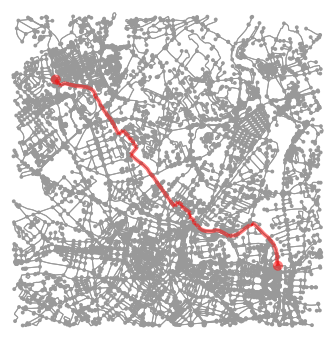

(<Figure size 589.035x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x17a102e1608>)

In [8]:
origin = ox.geo_utils.geocode('Maison du Lez, Montpellier, France') ## gives a tuple(latitude, longuitude)
## we transforme the tuple of coordinates into a point
origin_point = Point(origin[0], origin[1])

destination = ox.geo_utils.geocode('Place Eugène Bataillon, Montpellier, France')## gives a tuple(latitude, longuitude)
## we transforme the tuple of coordinates into a point
destination_point = Point(destination[0], destination[1]) 

## creatin the midpoint of origin and destination points
center = midpoint(origin_point, destination_point)
##creating the graph from the midpoint
G = ox.graph_from_point((center.lat, center.lon), network_type='walk', distance=2000)

## nearest nodes
origin_node = ox.get_nearest_node(G, origin)
destination_node = ox.get_nearest_node(G, destination)

## shortest path
route = nx.shortest_path(G, origin_node, destination_node)

## we plot the graph
ox.plot_graph_route(G, route)

# Points generating :

Now that we have our graph, we want to generate a list of points on the path between the origin and destination points. A starting point is the variable `route`, that is a list of tuples, eache tuple is the latitude and longuitude coordinates of a node in the path.

In [9]:
len(route)

76

We can see that `route`e has 76 nodes. We have two problems :

$\bullet$ The number of nodes is not enough to create a smooth animation, so we need a list of points that is more dense.

$\bullet$ The distances between each two points that are next to each other are very different, wich will affect our animation quality.

In order to solve these problems, we will have to create a more dense list of points. For that, we will need to create the following functions :

In [14]:

def distance(A,B): 
    """Calculate the distance between two points"""
    return ox.utils.great_circle_vec(A.lat, A.lon, B.lat, B.lon)

def bearing(A, B):
    """Calculate the bearing between two points"""
    return ox.geo_utils.get_bearing((A.lat,A.lon), (B.lat,B.lon))


In [15]:
def next_point(A,B,distance):
    '''given a point A, and a point B, returns a point with a given distance from A in the direction of B '''
    
    ## Radius of the Earth in km
    R = 6378.1 
    
    ## Bearing is degrees converted to radians.
    bear = radians(bearing(A,B)) 
    
    ## Distance in m converted to km
    d = distance/1000 
    
    ## convert degrees to radians
    lat1 = radians(A.lat) 
    lon1 = radians(A.lon) 
    
    ## applying the formula
    lat2 = asin( sin(lat1) * cos(d/R) + cos(lat1) * sin(d/R) * cos(bear) )
    lon2 = lon1 + atan2(sin(bear) * sin(d/R)* cos(lat1), cos(d/R)- sin(lat1)* sin(lat2))

    #convert back to degrees
    lat2 = degrees(lat2)
    lon2 = degrees(lon2)

    return Point(lat2, lon2)


Now in order to solve the problems mentioned above, we will start by calling the `osmnx` function `ox.plot.node_list_to_coordinate_lines`, this function, given a list of nodes, return a list of lines that together follow the path defined by the list of nodes, this will make sure that we have at least a point in the start and in the end of each edge in the path. Next, using the functions created above, we will remove some points that are too close to each others, keeping a minimum distance between each two next points. And finally, between each next points, we will create points that are perfectly aligned, with almost equal distance (of our choice) between them.

In [12]:
def points_generate(G, route, step = 10):
    """returnes a list of points that belong to the same path (route), of the graph G,
    with almost equal distance (step) between each tow points"""
    
    ## this function Given a list of nodes, return a list of lines that together follow the path defined by the list of nodes.
    ## we'll aply it on our route
    lines = ox.plot.node_list_to_coordinate_lines(G, route)
    
    ## creating an empty list
    ll =[]
    
    ## appending the elements of lines
    ## each element is a list of tuples
    for i in lines:
        for j in i:
            ll.append(j)
    ## first point : origin point
    list1 = []
    
    ## for each tuple in each list we append the tuple as a point
    for i in ll:
        list1.append(Point(i[1], i[0]))
    
    ## list2's first element = list1's
    list2 = [list1[0]]
    
    
    rep = list1[0]
    
    ## we remove the points that are too close to each other
    ## as thay are not perfectly aligned
    for i in range(len(list1)-1) :
        
        ## only append if the next point is 50m or more away from current one 
        if distance(rep, list1[i])>50:
            list2.append(list1[i])
            rep = list1[i]
    
    ## points' first element is list2's first one
    points = [list2[0]]
    
    ## between each two points, creat points perfectly aligned with equal distance between them
    ## this will make the animation more uniform
    for i in range(len(list2)-1) :
        if distance(list2[i],list2[i+1])>step:
            for j in np.arange(step, int(distance(list2[i],list2[i+1])), step):
                points.append(next_point(list2[i],list2[i+1], j))
            points.append(list2[i+1])    
        else:
            points.append(list2[i+1])
    return points


In [17]:
points = points_generate(G, route, step = 1)
print(len(points))

4392


## Note : The step
`step` in the previous function is an important parametre, as it controls the distance between each two next points. using a step equal to one meter, will generate more than 4000 points in our path, which can create a very smooth animation (but saving 4000 image is very memory and time consuming, so we choose to go for step = 10).


In [18]:
points = points_generate(G, route, step = 10)
print(len(points))

471


# Images generating :

## Translation :
Now that we have a dense list of points on our path, we want to be able to show an image of a __pedestrin__ in each one of those points. To do that, we will use the `matplotlib.offsetbox` function `AnnotationBbox`, the AnnotationBbox Artist creates an annotation using an OffsetBox, it will allow us to show images and textes in the coordinates we choose, see this [demo](https://matplotlib.org/3.1.0/gallery/text_labels_and_annotations/demo_annotation_box.html) for more details. To show what this function does, let's show a pedestrian in the origin point:

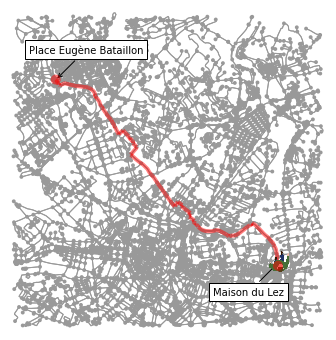

In [21]:
def insert_image (G, point, icon):
    """plot the given image, on top of the graph, in the specific given point"""
    fig, ax = ox.plot_graph_route(G, route, show=False, close=False)
    image  = Image.open(icon)
    
    ## storing the text in the container
    offsetbox1 = TextArea("Maison du Lez", minimumdescent=False)

    ## creating the artist
    ab = AnnotationBbox(offsetbox1, (origin_point.lon, origin_point.lat),
                        xybox=(-30, -30),
                        xycoords='data',
                        boxcoords="offset points",
                        arrowprops=dict(arrowstyle="->"))
    ## adding the artist
    ax.add_artist(ab)

    ## storing the text in the container
    offsetbox2 = TextArea("Place Eugène Bataillon", minimumdescent=False)

    ## creating the artist
    ab = AnnotationBbox(offsetbox2, (destination_point.lon, destination_point.lat),
                        xybox=(30, 30),
                        xycoords='data',
                        boxcoords="offset points",
                        arrowprops=dict(arrowstyle="->"))
    ## adding the artist
    ax.add_artist(ab)

    ## OffsetImage is the container that will contain our image
    im = OffsetImage(image, zoom=0.01)## zoom controls the size of th image
    
    ## AnnotationBbox will take an image and put it in the given coordinates
    ## in our case the coordinates are latitude and longuitude of our point 
    art = AnnotationBbox(im, (point.lon, point.lat), frameon = False) 
    ax.add_artist(art)
#     plt.savefig('life.png') ##uncomment this line if you want to save the figure
    plt.show()

## plot the image in the origin_point
insert_image(G, origin_point, "icons/pedestrian.png")

Now that we can show the pedestrian icon in the coordinates wa want, we can creat a mouvement of translation of the icon simply by showing it repeatedly in different points. But before we do that, we will control its rotation. 

## Rotation

Now that we can control the translation mouvement, we want to control the rotation of the icon. let's suppose that the front of our image is facing the point i, and its back is facing the point i-1, so in order to have the front of our image facing the point i+1, and its back is facing the point i, we must make a rotation with an angel given by : $$bearing(p(i-1), p(i)) + 180 - bearing(p(i+1), p(i)).$$
To do that, we will use the `PILLOW` package, and more specifically, we will use the `rotate()` method on the `Image` object. `rotate()` method rotates the image in counter clockwise direction.

## Pedestrian walking effect :

In order to make our animation better, we will add a walking effect to the pedestrian. the idea is to alternate between the icon image and its mirror_image, in order to give the pedestrian the walking effect. To create the mirror_image we will use the `PILLOW` package. and more specifically, we will use the `mirror()` methode of the `ImageOps` module.

Enough talking, it's show time. the function `images_generate` will use all what we discussed earlier to create the animation images. It will start by creating a folder named __temp__, and then, store images into it, those images will be used later to create our animation.

In [ ]:
## fuction to get some important setting depending on the type of transpotr we want
def settings(trans):
    """ returns settings for each type of transport"""
    if trans == 'car':
        icon = "icons/car.png"  ## the path to the icon
        icon_size = 0.045  ## control the size of the icon      
        start_angle = 110  ## the start angle that makes the icon looking the right direction in the start
        fig_title = 'Car animation' ## figure title
        image_name = 'car'  ## the name used to store the image in 'temp' folder, exemple : car1, car2, ...
        net_type='drive'  ## network type
    elif trans == 'bike':
        icon = "icons/bike.png"
        icon_size = 0.04
        start_angle = 10
        fig_title = 'Bike animation'
        image_name = 'bike'
        net_type='bike'
    elif trans == 'pedestrian':
        icon = "icons/pedestrian.png"
        icon_size = 0.01
        start_angle = 20
        fig_title = 'Pedestrian animation'
        image_name = 'pedestrian'
        net_type='walk'
    return (icon, icon_size,start_angle, fig_title, image_name, net_type)


In [45]:
plt.ioff() ## to avoit plotting the the figures every time saved
def images_generate(G, route, transport ):
    """Create a folder named 'temp', and store the animation images into it."""
    
    ## we'll need to define origin_point and destination_point
    origin = ox.geo_utils.geocode('Maison du Lez, Montpellier, France') ## gives a tuple(latitude, longuitude)
    origin_point = Point(origin[0], origin[1])

    destination = ox.geo_utils.geocode('Place Eugène Bataillon, Montpellier, France')## gives a tuple(latitude, longuitude)
    destination_point = Point(destination[0], destination[1]) 
    
    ## generating points
    points = points_generate(G, route, 10)
    
    ## getting setting of the type of transport
    (icon, icon_size, start_angle, fig_title, image_name, net_type) = settings(transport)
    
    ## icon opening (car, bike or pedestrian)
    im1  = Image.open(icon)
    
    ## in pedestrian case, we use mirroring in order to give 
    ## in order to give the impression that the pedestrian is walking
    if transport == 'pedestrian':
        im2 = ImageOps.mirror(im1)
    ## if not pedestrian, im2 will be just im1
    else:
        im2 = im1
    
    ## putting icon in track 
    im1 = im1.rotate(start_angle)
    im2 = im2.rotate(start_angle)
    
    ## saving current directory path
    start_path = os.getcwd()
    ## creating path for the folder 'temp' 
    path =os.path.join(os.getcwd(), 'temp')
    
    ## if 'temp' folder already exists, changing directory into it (in order to stor images)
    if 'temp' in os.listdir():
        os.chdir(path)
    ## if not, creating 'temp' folder and changing directory into it
    else:    
        os.mkdir('temp')
        os.chdir(path)
    
    ## for each point in the rode (route)
    for i in range(1,len(points)-1) :
        
        ## creating a ox graph figure
        fig, ax = ox.plot_graph_route(G, route, show=False, close=False)
        ## title
        plt.title(fig_title)
        
        ## controling the icon rotation, in order to have the rotation effect in our animation
        im1 = im1.rotate(bearing(points[i-1], points[i]) + 180 - bearing(points[i+1], points[i]))
        im2 = im2.rotate(bearing(points[i-1], points[i]) + 180 - bearing(points[i+1], points[i]))
        
        ## every five points, replace the im1 by im2
        ## if pedestrian, im2 will be the mirrored im1,
        ## this way the pedestrian looks walking
        if i % 5 ==0:
            tmp = im1
            im1 = im2
            im2 = tmp
            
        ## storing the icon_image in the container 
        img = OffsetImage(im1, zoom=icon_size)
        
        ## creating the artist
        art = AnnotationBbox(img, (points[i].lon, points[i].lat), frameon = False)
        
        ## copy the art container in orther to avoid an error
        new_ab=copy(art)
        
        ## adding the artist
        ax.add_artist(new_ab)
        
        ## storing the text in the container
        offsetbox1 = TextArea("Maison du Lez", minimumdescent=False)
        
        ## creating the artist
        ab = AnnotationBbox(offsetbox1, (origin_point.lon, origin_point.lat),
                            xybox=(-30, -30),
                            xycoords='data',
                            boxcoords="offset points",
                            arrowprops=dict(arrowstyle="->"))
        ## adding the artist
        ax.add_artist(ab)

        ## storing the text in the container
        offsetbox2 = TextArea("Place Eugène Bataillon", minimumdescent=False)
        
        ## creating the artist
        ab = AnnotationBbox(offsetbox2, (destination_point.lon, destination_point.lat),
                            xybox=(30, 30),
                            xycoords='data',
                            boxcoords="offset points",
                            arrowprops=dict(arrowstyle="->"))
        ## adding the artist
        ax.add_artist(ab)
        
        ## saving the fig as a png image
        plt.savefig(image_name+str(i)+'.png')
        
        ## closing the fig
        plt.close('all')
        
    ## returning to start directory
    os.chdir(start_path)
    

In [24]:
images_generate(G, route, 'pedestrian' )

Finally, our images are already created, all is left is to create the animation by repeatedly displaying them one by one. For that we will use the famous `animation.FuncAnimation()`. The `animation.FuncAnimation()` takes as input `np.arrays` so we will transforme our images to `np.arrays` using `imageio.imread()`, of the package `imageio`.

In [32]:
    
def animate(transport, create_images = False):
    """create animation of a pedestrian, a car, or a a bike, eather by creating, on the fly, a folder named "temp" 
    and storing images into it, or by already existing images """
    ## getting setting of the type of transport
    (icon, icon_size, start_angle, fig_title, image_name, net_type) = settings(transport)
    
    ## Creating the graph for animation
    origin = ox.geo_utils.geocode('Maison du Lez, Montpellier, France') ## gives a tuple(latitude, longuitude)
    ## we transforme the tuple of coordinates into a point
    origin_point = Point(origin[0], origin[1])

    destination = ox.geo_utils.geocode('Place Eugène Bataillon, Montpellier, France')## gives a tuple(latitude, longuitude)
    ## we transforme the tuple of coordinates into a point
    destination_point = Point(destination[0], destination[1]) 

    ## creatin the midpoint of origin and destination points
    center = midpoint(origin_point, destination_point)
    ##creating the graph from the midpoint
    G = ox.graph_from_point((center.lat, center.lon), network_type = net_type, distance=2000)

    ## nearest nodes
    origin_node = ox.get_nearest_node(G, origin)
    destination_node = ox.get_nearest_node(G, destination)

    ## shortest path
    route = nx.shortest_path(G, origin_node, destination_node)
    
    ## if we want to generate images on the fly with this function
    ## creating the 'temp' folder and generating images into it
    if create_images:
        images_generate(G, route, transport)
    
    ## saving current directory path
    start_path = os.getcwd()
    
    ## changing directory, getting to 'temp' folder
    path =os.path.join(os.getcwd(), 'temp')
    os.chdir(path)
    
    ## creating list to stor images from 'temp' folder
    imagelist = []
    
    ## storing image by image
    for i in range(1, len(points)-1):
        imagelist.append(imageio.imread(image_name + str(i) + '.png'))

    ## creating figure
    fig = plt.figure(figsize=(9, 9)) 
    ## without axis
    plt.axis('off')

    # making axesimage object
    im = plt.imshow(imagelist[0], cmap=plt.get_cmap('jet'), vmin=0, vmax=255) ## vmin and vmax get the color map correct

    # function to update figure
    def updatefig(j):
        # set the data in the axesimage object
        im.set_array(imagelist[j])
        # return the artists set
        return [im]
    
    # starting animation
    anim = animation.FuncAnimation(fig, updatefig, frames=range(537), 
                                  interval=50, blit=True)
    plt.show()
    
    ## returning to start directory
    os.chdir(start_path)
    
    return anim



<IPython.core.display.Javascript object>


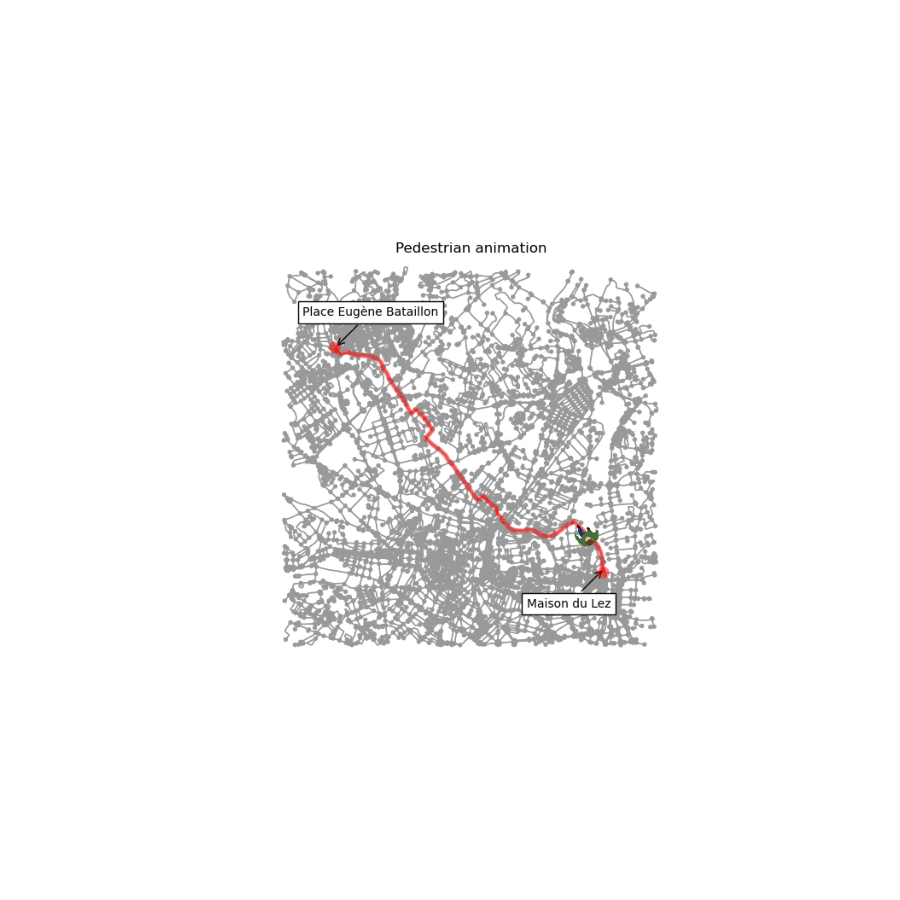

In [46]:
animate('pedestrian', create_images = True)

### Note :
We can call the function `images_generate` inside the previous function `animate`, just by sitting the `create_images` parametre to __True__, in this case, the function `animate` will create the __temp__ folder and store images into it, before using these images to creat animation. But if the folder is already created, there is no need to create it again, so we just let the `create_images` parametre set to __False__.